### Aluno: Wesley Wevertton de Azevedo Palmeira - 201621250039
### Disciplina: Sinais e Sistemas


### TAREFA 1: Reproduzir e explicar os resultados do artigo do <a href='https://dspillustrations.com/pages/posts/misc/the-sound-of-harmonics-approximating-instrument-sounds-with-fourier-series.html'>link 2</a>, considerando ao menos três amostrasde som disponíveis neste site.

#### No <a href='https://dspillustrations.com/pages/posts/misc/fourier-series-and-harmonic-approximation.html'>link 1</a>,  foi mostrado como diferentes números de harmonicas se aproximam de funções períodas artificiais. O objetivo agora, é considerar um período de um som de um instrumento (no nosso caso alguns sons de flautas, considerando ainda que o som tocado seja períodico), expandir sua forma de onda em seno e cossenos de frequências harmônicas e, reconstruir o sinal original a partir dele.

In [68]:
def fourierSeries(period, N):
    """Cálculo dos coeficientes da série de fourier até o n-ésimo harmônico"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

#### A função definida como fourierSeries tem o objetivo de calcular os coeficientes da série de fourier até a n-ésima harmônica em forma de seno e cossenos 

In [69]:
def reconstruct(P, anbn):
    """Soma os senos e cossenos de acordo com os coeficientes para reconstruir a onda original"""
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

#### A função definida como reconstruct tem o objetivo de somas os senos e cossenos de acordo com os coeficientes da serie de fourrier e construir a forma de onde original

In [70]:
from scipy.io import wavfile
import requests
from io import BytesIO
from IPython.display import Audio
def loadSound(url):
    R = requests.get(url)
    rate, data = wavfile.read(BytesIO(R.content))
    data = data * 1.0 / (abs(data).max())
    if len(data.shape) > 1:  # Para Sons Stereo, estou considerando apenas usar um canal de audio
        data = data[:,0]
    return data, rate

# A URL dos sons WAV, note que o site é diferente do proposto no documento do projeto, isso foi acordado com o professor 
# via whatsapp, os sons são os sons de 3 flautes de diferentes timbres, os sons aparentam ser constantes, logo são periodicos
urls = ["https://freewavesamples.com/files/Alesis-Fusion-Shakuhachi-C5.wav",
       "https://freewavesamples.com/files/E-Mu-Proteus-FX-Ocarina-C5.wav",
       "https://freewavesamples.com/files/Korg-M3R-Pan-Pipes-C5.wav"]
sounds = []
for url in urls:
    sound, rate = loadSound(url)
    sounds.append((sound, rate))

#### A função loadSound tem o objetivo de carregar os sons das ondas a serem analisadas.

In [71]:
# Esta função foi criada apenas para printar os sons um ao lado do outro no jupyter notebook
def audioSideBySide(name1, audio1, name2, audio2):
    text = '%s %s \n %s %s' % (name1, audio1._repr_html_(), name2, audio2._repr_html_())
    display(HTML(text))

In [72]:
from IPython.core.display import HTML
#Este trecho de código mostra os sons que foram "baixados" no jupyter notebook.
for n, s in enumerate(sounds):
    display(HTML("Som de flauta %d" % (n+1) + Audio(data=s[0], rate=s[1])._repr_html_()))

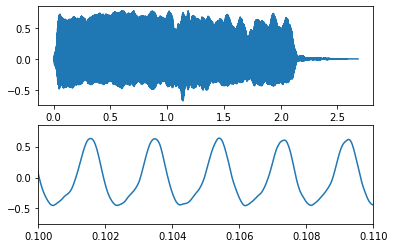

In [73]:
import numpy as np
import matplotlib.pyplot as plt
t = np.arange(len(sounds[0][0])) / sounds[0][1]
plt.subplot(211)
plt.plot(t, sounds[0][0])
plt.subplot(212)
plt.xlim(0.1,0.11)
plt.plot(t, sounds[0][0])

#### Olhando para a primeira figura a gente não consegue ver nenhuma periodicidade, mas olhando para a segunda (uma versão ampliada da primeira) podemos perceber que se trata sim de um sinal periodico bem definido.

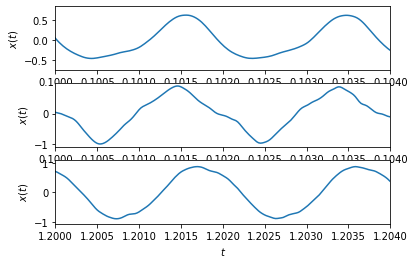

In [87]:
def extractPeriod(data, rate, t_start, t_end):
    if(t_start == 0.1):
        plt.xlim(0.100,0.104)
    else:
        plt.xlim(1.200,1.204)
    t = np.arange(0,len(data))/rate
    plt.plot(t, data)

    duration = t_end - t_start
    plt.xlabel('$t$'); plt.ylabel('$x(t)$');


    sample_start = int(t_start * rate)
    sample_end = int(t_end*rate)

    period = data[sample_start:sample_end]
    audioSideBySide("Som original", Audio(data=data,rate=rate),
                    "Som do período extraído", Audio(np.tile(period, int(1/duration)), rate=rate))
    return period, rate

periods = []
rates = []
# Manualmente foi encontrado o início e o fim do período de cada sinal, isso foi feito observando a forma de onda e
# também escutando a som do período extraído.
periodBounds = [(0.100,0.102),
                (0.100,0.102),
                (1.200,1.202)]
for n, (S, P) in enumerate(zip(sounds, periodBounds)):
    plt.subplot(len(sounds), 1, n+1)
    period, rate = extractPeriod(S[0], S[1], P[0], P[1])
    periods.append(period); rates.append(rate)

#### Em um primeiro momento podemos ver cada som e seu período extraído lado a lado, podemos perceber que a repetição do período extraído se aproxima muito do som original. No segundo momento podemos ver os gráficos relativos a dois períodos, para firmar ainda mais a periodicidade do sinal.

In [75]:
def approximateUpToNthHarmonic(period, rate, N):
    t = np.arange(len(period)) / rate
    duration = t.max()
    F = fourierSeries(period, N)
    powers = np.sqrt(np.sum(F**2, axis=1))
    reconstructed = reconstruct(len(period), F)
    plt.figure()
    plt.subplot(121)
    plt.plot(t*1000, period, label='Som original') 
    plt.plot(t*1000, reconstructed, label='Reconstruído')
    plt.subplot(122)
    plt.stem(powers,use_line_collection = True)
    
    audioSideBySide("Som Original", Audio(data=np.tile(period, int(0.7/duration)), rate=rate), 
                    "Som reconstruído com %d harmônicas" % N, Audio(data=np.tile(reconstructed, int(0.7/duration)), rate=rate))

#### A função approximateUpToNthHarmonic considera o período de um sinal, calcula sua série de Fourier e o reconstroi até a N-ésima harmônica. Vamos analisando a construção do sinal o reconstruindo com primeiramente apenas uma harmônica e depois aumentando esse número e observando o resultado.

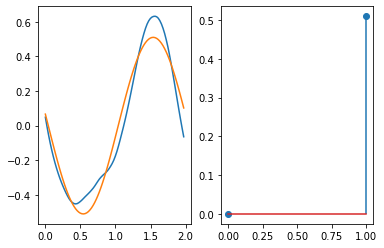

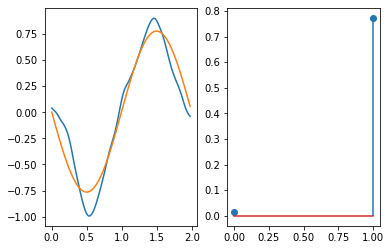

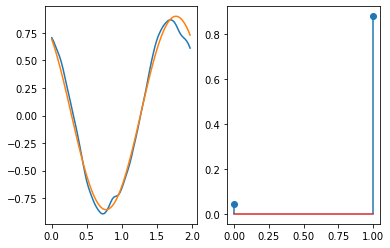

In [76]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 1)

#### Percebemos graficamente que não conseguimos reconstruir o sinal com boa precisão, consequentemente o som se torna bem diferente do original. Vamos agora verificar para o dobro de harmônicas, ou seja, 2 harmônicas.

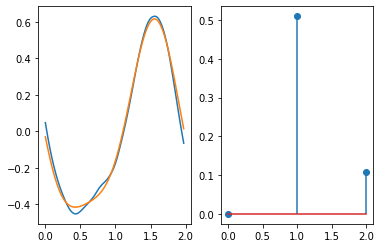

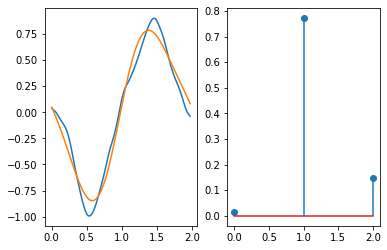

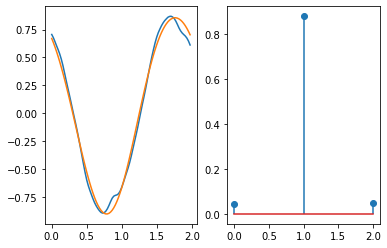

In [88]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 2)

#### Podemos perceber que ja temos uma precisão maior na reconstrução do sinal, mas ainda não é uma reconstrução rica em detalhes, como por exemplo o segundo sinal, ele perde detalhes essenciais na sua reprodução, principalmente nas suas oscilações mais intensas, como podemos perceber graficamente. Vamos agora verificar com o número de 5 harmônicas

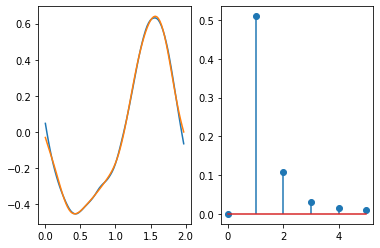

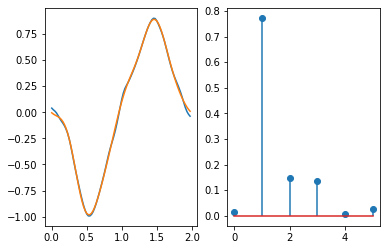

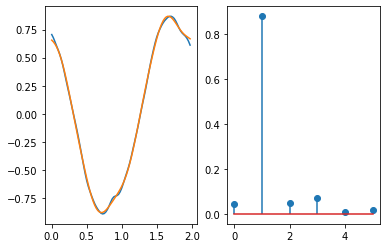

In [89]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 5)

#### Vemos que agora o sinal ja foi bem reconstruido e se aproxima muito do original, porém, por exemplo no primeiro sinal, no começo e no fim dele, temos uma diferença que pode ser verificada graficamente e para quem tem um bom "ouvido" escutando o som também da para perceber. Vamos agora crescendo esse número de harmônicas e percebendo o que vai acontecendo.

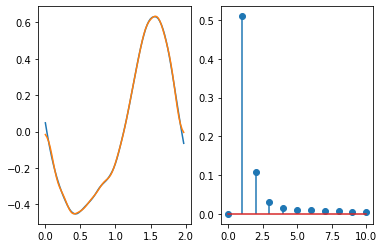

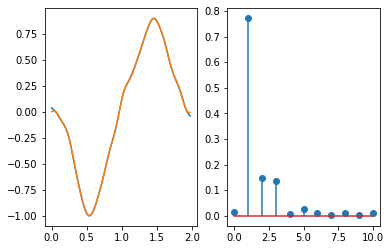

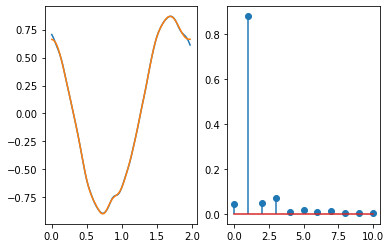

In [90]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 10)

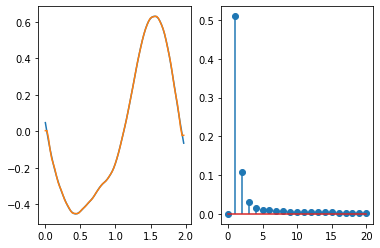

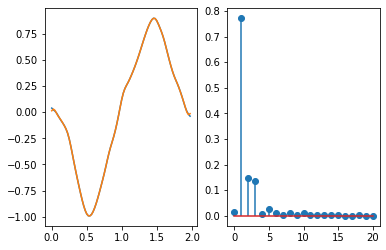

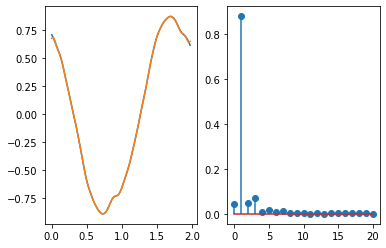

In [96]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 20)

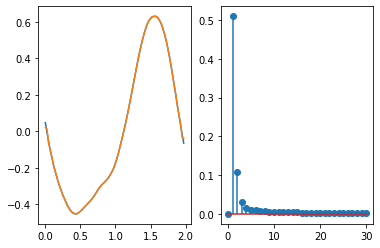

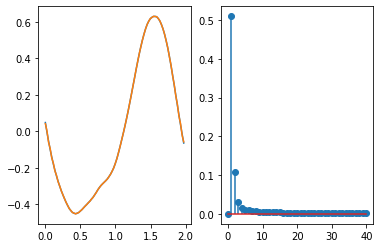

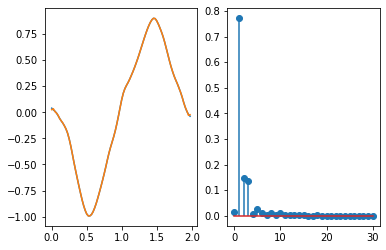

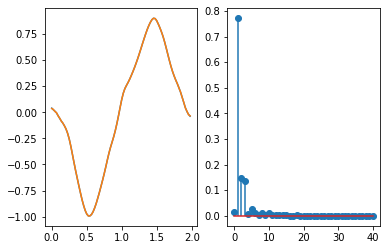

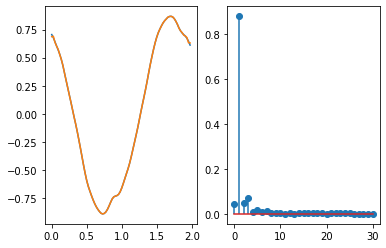

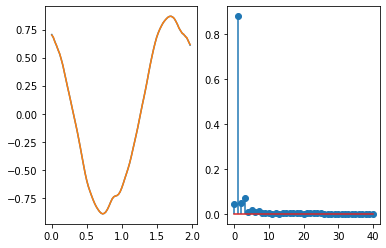

In [98]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 30)
    approximateUpToNthHarmonic(P, R, 40)

#### Logo, percebe que ao chegar em 40 harmônicas, nosso sinal ja é reconstruído com bastante precisão, se diferenciando muito pouco do som original, uma diferença que é imperceptível ao ouvido humano e podemos observar bem isso nos gráificos ilustrados para cada sinal e cada harmônica que foi reconstruída.

#### O objetivo agora é reconstruir uma onda quadrada com série de Fourier. Neste primeiro momento vamos gerar uma onda quadrada e vê como ela soa.

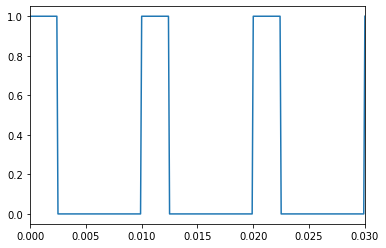

In [93]:
Fs = 10000
F = 100
N = Fs/F
T=1
period = (np.arange(N) < (N/4)).astype(float)
t = np.arange(0, T, 1/Fs)
signal = np.tile(period, T*F)
plt.xlim(right=0.03)
plt.plot(t, signal)
Audio(data=signal, rate=Fs)

#### Ela soa um pouco desconfortável, quase como a gente tem um cabo de guitarra ou microfone com problemas, porém da para escutar as frequencias baixas e altas do sinal. Vamos agora, fazer o mesmo procedimento que fizemos para os áudios das falutas e ir reconstruindo o sinal a partir de 1, 3, 5, 11, 21 e finalmente 49 harmônicas e ver seu comportamento grafico e auditivo.

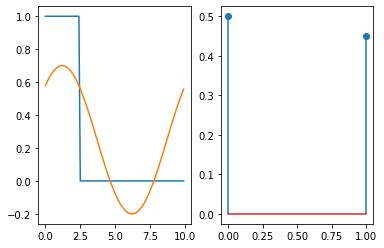

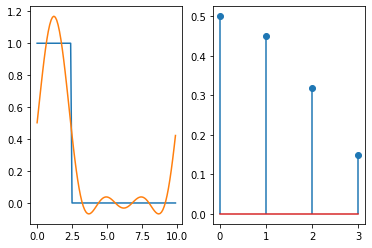

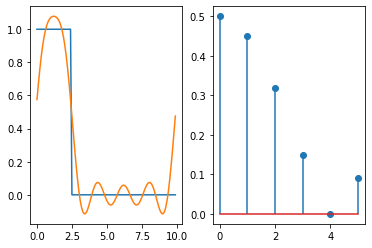

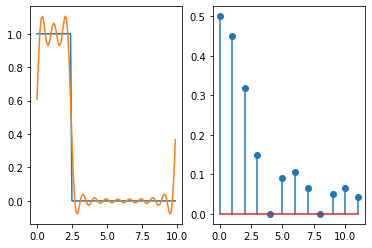

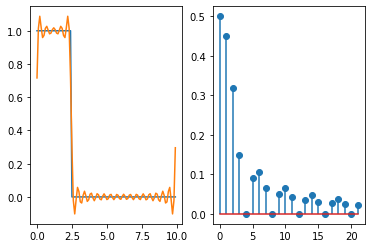

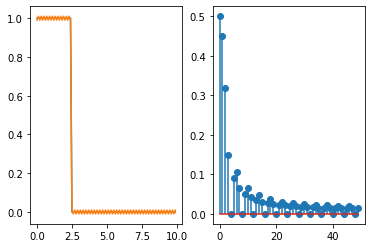

In [99]:
for N in [1, 3, 5, 11, 21, 49]:
    approximateUpToNthHarmonic(period, Fs, N)

#### Assim como os sons da flautas, mesma situação ocorre para uma onda quadrada, precisamos de muitas harmônicas para construir o sinal com precisão, se observarmos o gráfico com 21 harmônicas (um número ja considerável) percebemos que o sinal ainda possui muita diferença do sinal original, mas quando aumentamos isso para mais que o dobro (49 harmônicas) o sinal ja se aproxima bastante do original. Portanto, percebemos que quanto mais harmônicas utilizarmos para a reconstrução do sinal, mais vamos ter uma maior precisão neste trabalho.